# Making Business Decisions Based on Data Project

## Project description

Context

You are an analyst at a big online store. Together with the marketing department, you've compiled a list of hypotheses that may help boost revenue.

You need to prioritize these hypotheses, launch an A/B test, and analyze the results.

### Description of the data

#### Data used in the first part of the project

Hypotheses— brief descriptions of the hypotheses

Reach— user reach, on a scale of one to ten

Impact— impact on users, on a scale of one to ten

Confidence— confidence in the hypothesis, on a scale of one to ten

Effort— the resources required to test a hypothesis, on a scale of one to ten. The higher the Effortvalue, the more resource-intensive the test.

#### Data used in the second part of the project

transactionId— order identifier

visitorId— identifier of the user who placed the order

date— of the order

revenue— from the order

group— the A/B test group that the user belongs to

#### Data used in the third part of the project

date— date

group— A/B test group

visits— the number of visits on the date specified in the A/B test group specified

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
from scipy import stats

In [2]:
try:
    hypotheses=pd.read_csv('/datasets/hypotheses_us.csv')
except:
    hypotheses=pd.read_csv('C:/Projects/datasets/hypotheses_us.csv')
hypotheses

,Hypothesis;Reach;Impact;Confidence;Effort
0,Add two new channels for attracting traffic. T...
1,Launch your own delivery service. This will sh...
2,Add product recommendation blocks to the store...
3,Change the category structure. This will incre...
4,Change the background color on the main page. ...
5,Add a customer review page. This will increase...
6,Show banners with current offers and sales on ...
7,Add a subscription form to all the main pages....
8,Launch a promotion that gives users discounts ...


   The first dataset doesn't look nice, let's make it useful for analysis.
   Further analysis shows that there are no duplicates or missing values in hypotheses_new dataset.

In [3]:
try:
    hypotheses_new=pd.read_csv('/datasets/hypotheses_us.csv', sep=';', decimal=',')
except:
    hypotheses_new=pd.read_csv('C:/Projects/datasets/hypotheses_us.csv', sep=';', decimal=',')
hypotheses_new

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [4]:
hypotheses_new.duplicated().sum()

0

In [5]:
hypotheses_new.isna().sum()

Hypothesis    0
Reach         0
Impact        0
Confidence    0
Effort        0
dtype: int64

let's load the second data set.

In [6]:
try:
    orders=pd.read_csv('/datasets/orders_us.csv')
except:
    orders=pd.read_csv('C:/Projects/datasets/orders_us.csv')
orders

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A


In [7]:
orders.duplicated().sum()

0

In [8]:
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


In [10]:
orders['date']=pd.to_datetime(orders['date'],dayfirst=True)

   There are no duplicates or missing values in orders. But let's check if all visitors belong to one group. As we see, the answer is 'no'.They should be dropped for the purity of the experiment. Also the 'date' data type should be changed.

In [11]:
orders[orders['visitorId'].duplicated(keep=False)].sort_values(by=['visitorId'], ascending=False)


,transactionId,visitorId,date,revenue,group
662,1811671147,4266935830,2019-08-29,1220.2,A
682,1216533772,4266935830,2019-08-29,1220.2,B
60,1421016313,4256040402,2019-08-16,875.5,B
263,2575861846,4256040402,2019-08-18,170.8,B
187,2048878902,4256040402,2019-08-17,25.8,A
...,...,...,...,...,...
26,2223239646,199603092,2019-08-15,55.7,A
823,2971973105,199603092,2019-08-27,45.9,A
134,62794304,199603092,2019-08-22,110.3,A
71,3679129301,8300375,2019-08-01,165.7,B


In [12]:
#Creating a list of users we need to drop
visitor_drop = orders.groupby('visitorId')['group'].nunique().reset_index().query('group !=1')['visitorId'].to_list()

#Droping users of visitor_drop from orders table
orders_filt = orders[~orders['visitorId'].isin(visitor_drop)] 
orders_filt

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


   Now the second data set looks nice.
   
   Let's look at the third data set

In [13]:
try:
    visits=pd.read_csv('/datasets/visits_us.csv')
except:
    visits=pd.read_csv('C:/Projects/datasets/visits_us.csv')
visits

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [14]:
visits.duplicated().sum()

0

In [15]:
visits.isna().sum()

date      0
group     0
visits    0
dtype: int64

In [16]:
visits['date']=pd.to_datetime(visits['date'],dayfirst=True)

We needed just to change data type in 'date' column. Everything is ok now.

                                Part 1. Prioritizing Hypotheses

Our firs step will be to prioritize hypotheses. To do this it would be good to display the names of the hypotheses in their entirety. Arter that we'll apply the ICE and RICE frameworks.

In [17]:
 pd.options.display.max_colwidth= 200

In [18]:
hypotheses_new

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


In [19]:
#Apply the ICE framework to prioritize hypotheses. Sort them in descending order of priority.
hypotheses_new['ICE']=hypotheses_new['Impact']*hypotheses_new['Confidence']/hypotheses_new['Effort']
hypotheses_new.ICE= hypotheses_new.ICE.round(2)

hypotheses_new.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Effort,ICE
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.20
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.33
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.20
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.00
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.00
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.00
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.33
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.12
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.00


In [20]:
#Apply the RICE framework to prioritize hypotheses. Sort them in descending order of priority.
hypotheses_new['RICE']=hypotheses_new['Reach']*hypotheses_new['Impact']*hypotheses_new['Confidence']/hypotheses_new['Effort']

hypotheses_new.sort_values( by='RICE', ascending=False)


,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.20,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.00,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.33,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.00,40.0
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.20,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.12,9.0
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.00,4.0
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.33,4.0
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.00,3.0


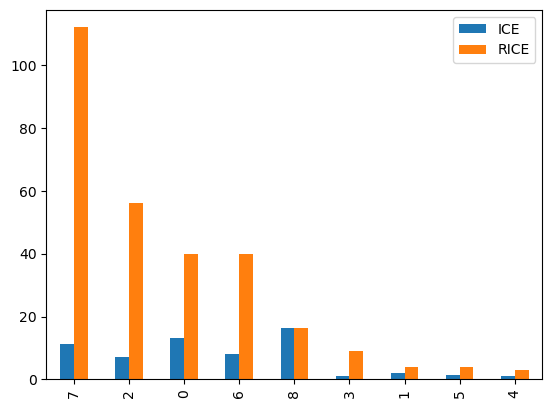

In [21]:
#Show how the prioritization of hypotheses changes when you use RICE instead of ICE. Provide an explanation for the changes.
hypotheses_bar=hypotheses_new[['Hypothesis', 'ICE', 'RICE']]
hypotheses_bar.sort_values(by='RICE', ascending=False).plot(kind='bar')
plt.show()

   According to the ICE parameter the hypotheses with the highest priority are:
   1. Launch a promotion that gives users discounts on their birthdays	
   2. Add two new channels for attracting traffic. This will bring 30% more users
   3. Add a subscription form to all the main pages. This will help you compile a mailing list
     
   But if the RICE parameter can be used the highest priority have hypotheses:
   1. Add a subscription form to all the main pages. This will help you compile a mailing list
   2. Add product recommendation blocks to the store's site. This will increase conversion and average purchase size"
   3. Add two new channels for attracting traffic. This will bring 30% more users 
    
   These hypotheses become the leaders because they can reach more people than others. This is important for our goals, so I would recommend to choose the hypothesis: Add a subscription form to all the main pages. This will help you compile a mailing list'.

                                        Part 2. A/B Test Analysis

   For our future analysis we need to find a unique combination of date and group and join to the rest of the data in an aggregated form.  It helps to find the quantity of orders(transactionId), buyers(visitorId) and total revenue.

In [22]:
orders_filt

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


In [23]:
datesGroups = orders_filt[['date','group']].drop_duplicates() 
datesGroups

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


In [24]:
ordersAggregated = (datesGroups
                    .apply(lambda x: orders_filt[np.logical_and(orders_filt['date'] <= x['date'], orders_filt['group'] == x['group'])]\
                           .agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 
                                 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group'])
                   )
ordersAggregated

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,2266.6
66,2019-08-01,B,17,17,967.2
175,2019-08-02,A,42,36,3734.9
173,2019-08-02,B,40,39,3535.3
291,2019-08-03,A,66,60,5550.1
...,...,...,...,...,...
533,2019-08-29,B,510,490,74576.7
757,2019-08-30,A,460,437,52363.7
690,2019-08-30,B,531,511,77863.5
958,2019-08-31,A,468,445,53212.0


In [25]:
#Graph cumulative revenue by group. Make conclusions and conjecture
cumulativeRevenueA = ordersAggregated[ordersAggregated['group']=='A'][['date','revenue', 'transactionId']]
cumulativeRevenueA.sort_values(by=['date'], ascending=True)

,date,revenue,transactionId
55,2019-08-01,2266.6,23
175,2019-08-02,3734.9,42
291,2019-08-03,5550.1,66
499,2019-08-04,6225.6,77
719,2019-08-05,7623.6,99
362,2019-08-06,8292.0,114
580,2019-08-07,10234.0,130
835,2019-08-08,11638.8,144
569,2019-08-09,13734.0,155
859,2019-08-10,16121.5,170


In [26]:
cumulativeRevenueB = ordersAggregated[ordersAggregated['group']=='B'][['date','revenue', 'transactionId']]
cumulativeRevenueB.sort_values(by=['date'], ascending=True)

,date,revenue,transactionId
66,2019-08-01,967.2,17
173,2019-08-02,3535.3,40
383,2019-08-03,4606.9,54
498,2019-08-04,6138.5,68
699,2019-08-05,7587.8,89
360,2019-08-06,10957.1,112
581,2019-08-07,14392.7,135
789,2019-08-08,16772.6,157
567,2019-08-09,18428.8,176
794,2019-08-10,20103.6,198


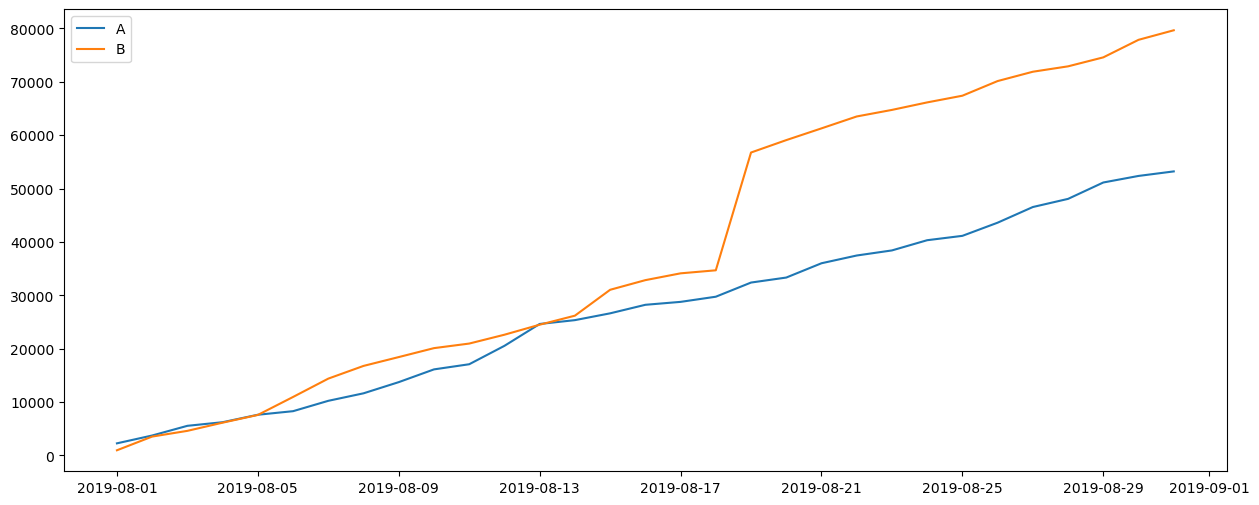

In [27]:
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.show()

   The graph above shows total revenue by group. According to the graph, total revenue increased during the period under study both in group A and group B. First two weeks the resuts in these groups were very close to each other, but than the total revenue in group B increased much faster than total revenue in group A.
   Now it is time to find cumulative average order size by group.

In [28]:
#Graph cumulative average order size by group. Make conclusions and conjectures.

cumulativeRevenueA['cumul_avch']=cumulativeRevenueA['revenue']/cumulativeRevenueA['transactionId']
cumulativeRevenueA['cumul_avch']=cumulativeRevenueA['cumul_avch'].round(2)
cumulativeRevenueA

,date,revenue,transactionId,cumul_avch
55,2019-08-01,2266.6,23,98.55
175,2019-08-02,3734.9,42,88.93
291,2019-08-03,5550.1,66,84.09
499,2019-08-04,6225.6,77,80.85
719,2019-08-05,7623.6,99,77.01
362,2019-08-06,8292.0,114,72.74
580,2019-08-07,10234.0,130,78.72
835,2019-08-08,11638.8,144,80.82
569,2019-08-09,13734.0,155,88.61
859,2019-08-10,16121.5,170,94.83


In [29]:
cumulativeRevenueB['cumul_avch']=cumulativeRevenueB['revenue']/cumulativeRevenueB['transactionId']
cumulativeRevenueB['cumul_avch']=cumulativeRevenueB['cumul_avch'].round(2)
cumulativeRevenueB

,date,revenue,transactionId,cumul_avch
66,2019-08-01,967.2,17,56.89
173,2019-08-02,3535.3,40,88.38
383,2019-08-03,4606.9,54,85.31
498,2019-08-04,6138.5,68,90.27
699,2019-08-05,7587.8,89,85.26
360,2019-08-06,10957.1,112,97.83
581,2019-08-07,14392.7,135,106.61
789,2019-08-08,16772.6,157,106.83
567,2019-08-09,18428.8,176,104.71
794,2019-08-10,20103.6,198,101.53


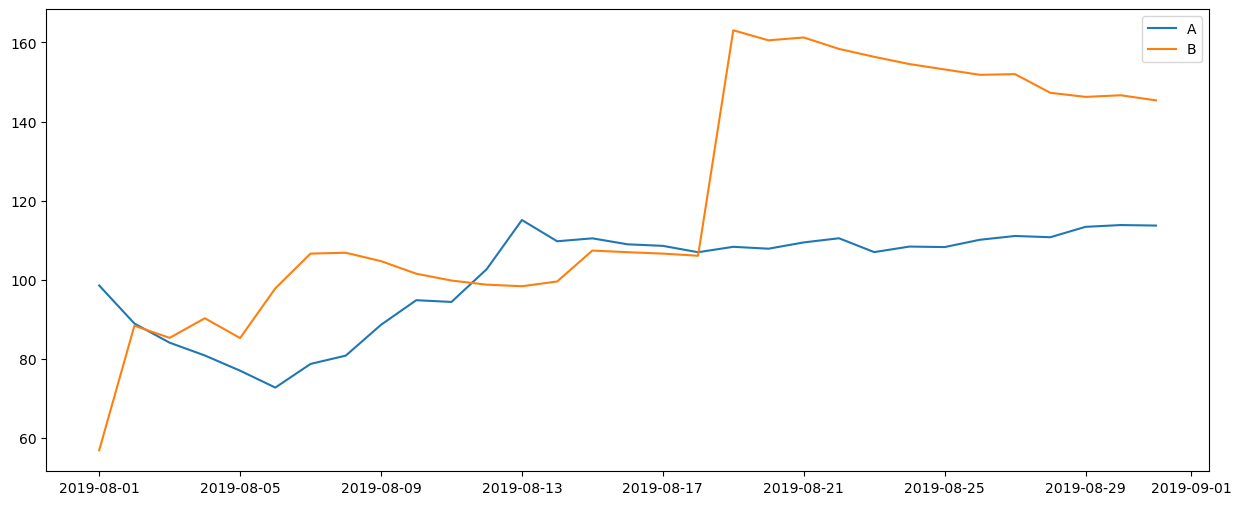

In [30]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['cumul_avch'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['cumul_avch'], label='B')
plt.legend()
plt.show()

   At the begining of the study (01.08.2019) сumulative average check was higher in the group A. From the 2nd till the 18th of August the values were close to each other in the groups under study. On August 19 сumulative average check in group B increased significantly while this indicator in group A stayed the same till the end of study. Despite the fact that the сumulative average check in group B slightly decreased it stayed higher than in group A.

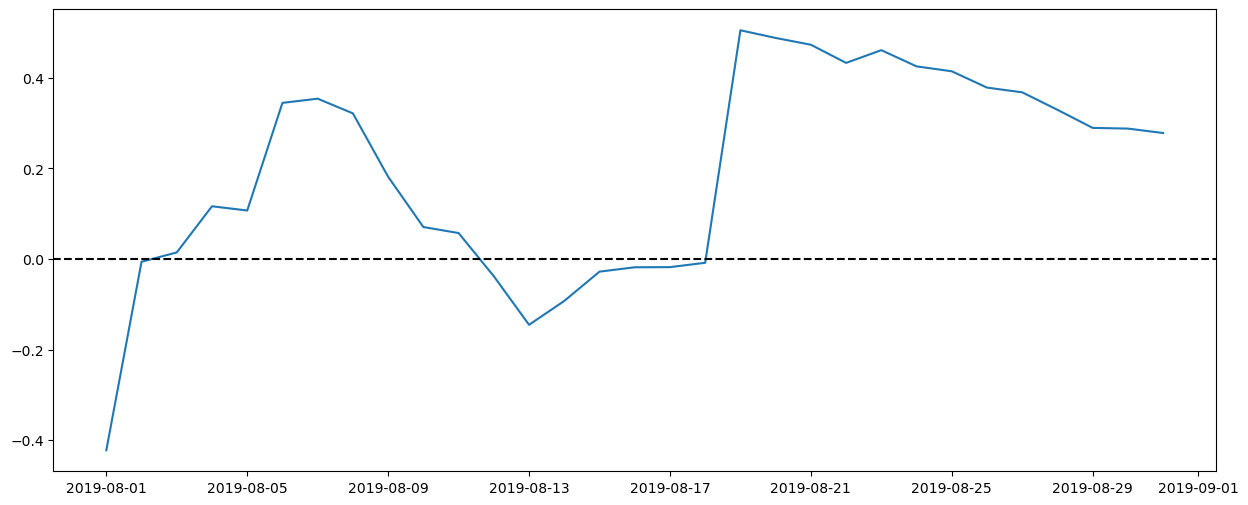

In [31]:
#Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and conjectures.

mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['transactionIdB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['transactionIdA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

   The graph above shows the difference in cumulative average order size between the groups. We can see that group B's results are getting a little bit worse last days but still are 30% higher than group A's.

In [32]:
mergedCumulativeRevenue.head()

,date,revenueA,transactionIdA,cumul_avchA,revenueB,transactionIdB,cumul_avchB
0,2019-08-01,2266.6,23,98.55,967.2,17,56.89
1,2019-08-02,3734.9,42,88.93,3535.3,40,88.38
2,2019-08-03,5550.1,66,84.09,4606.9,54,85.31
3,2019-08-04,6225.6,77,80.85,6138.5,68,90.27
4,2019-08-05,7623.6,99,77.01,7587.8,89,85.26


   The next step is to calculate each group's conversion rate as the ratio of orders to the number of visits for each day. For this purpose we merge group A and group B data frames with visits dataframe, that contains information about visits. 

In [33]:
#Calculate each group's conversion rate as the ratio of orders to the number of visits for each day.
#Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures.
visitsAggregated = datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])


In [34]:
#Then merge them to aggregated orders
ordersAggregated = ordersAggregated.merge(visitsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])


In [35]:
#Create a conversion column
ordersAggregated['conversion']= ordersAggregated['transactionId']/ordersAggregated['visits']


In [36]:
#Select groups
cumulativeDataA = ordersAggregated[ordersAggregated['group']=='A']

cumulativeDataB = ordersAggregated[ordersAggregated['group']=='B']

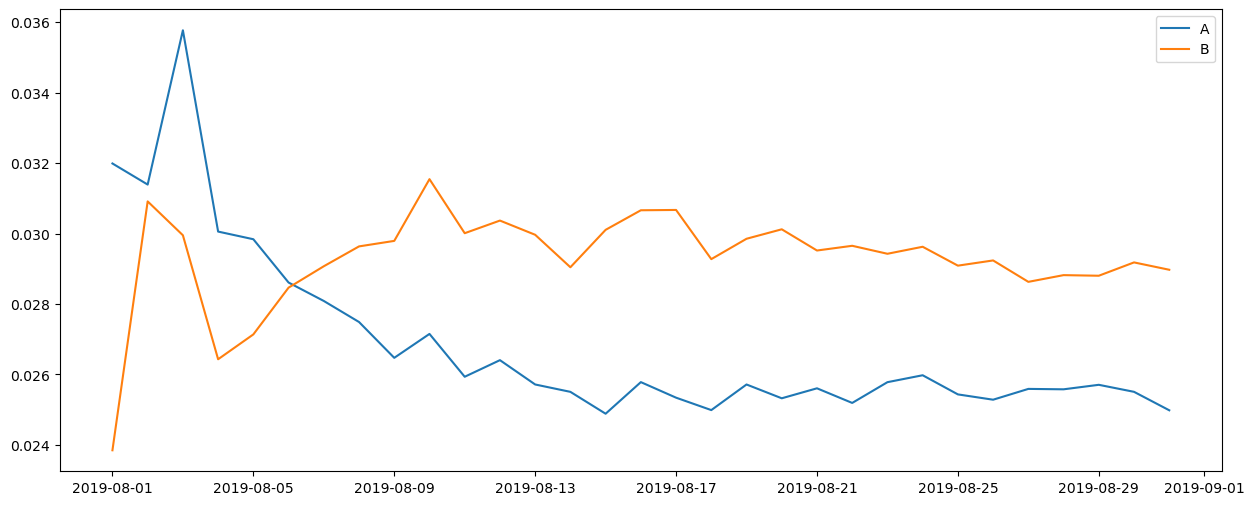

In [37]:
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.show()

According to results, group B has higher conversion.

    Let's check the number of orders per user.

In [38]:
#Plot a scatter chart of the number of orders per user. 
ordersByUsers = (
    orders_filt.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['visitorId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))


      visitorId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


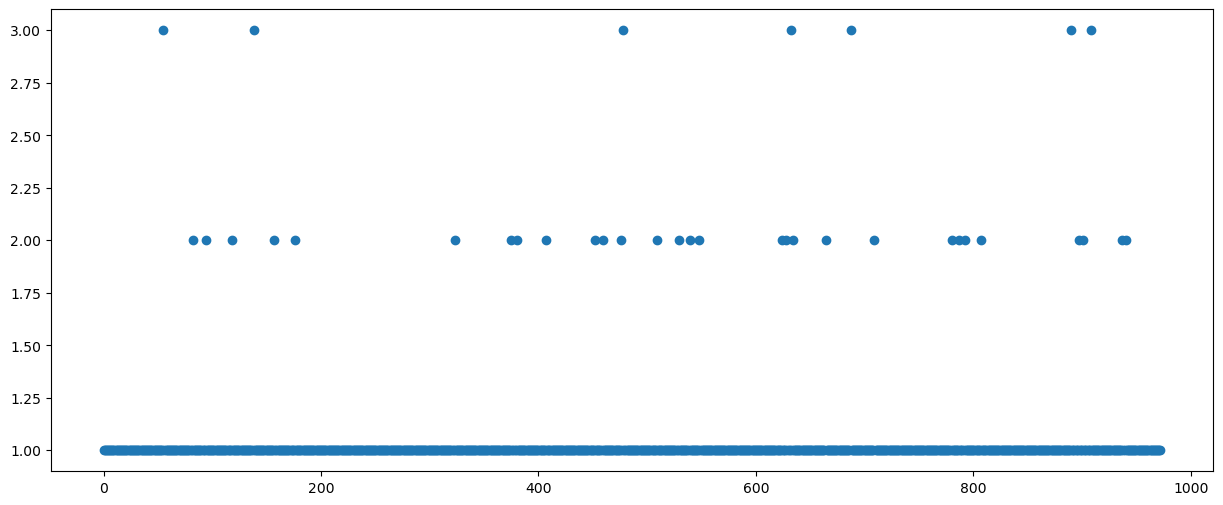

In [39]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 
plt.show()

In [40]:
#Calculate the 95th and 99th percentiles for the number of orders per user. 
#Define the point at which a data point becomes an anomaly.
print(np.percentile(ordersByUsers['orders'], [90, 95, 99])) 

[1. 1. 2.]


 During the study period one user made mostly (95%) one purchase. Just 1% of users made 2 or 3 purchases. We can call this 1% an outliers and can drop them in the future.

   Let's investigate order prices. 

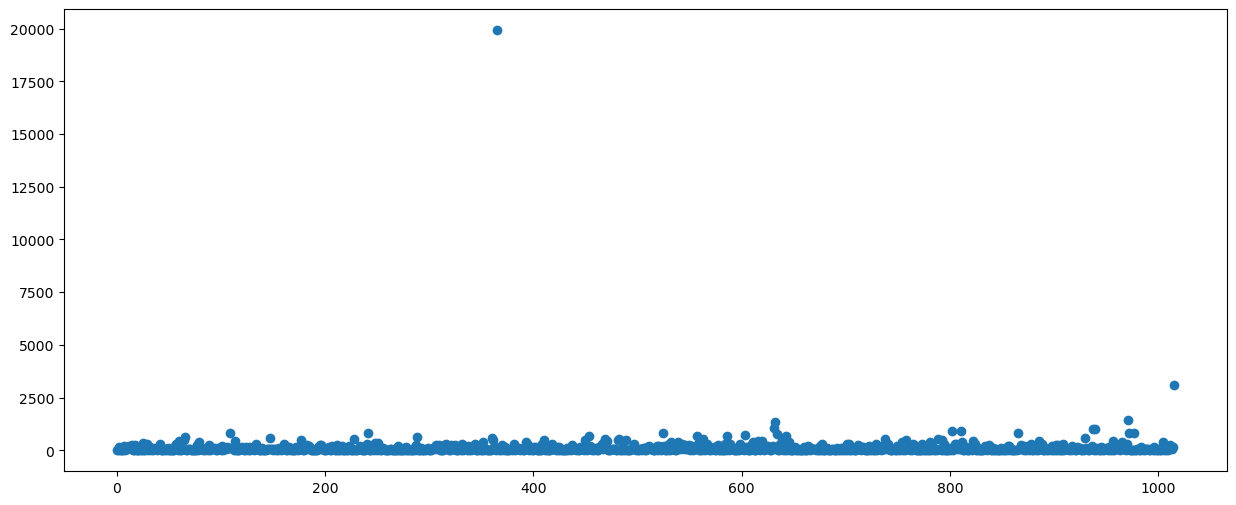

In [41]:
#Plot a scatter chart of order prices. Make conclusions and conjectures.
x_values = pd.Series(range(0,len(orders_filt)))

plt.scatter(x_values, orders_filt['revenue']) 
plt.show()

In [42]:
orders_filt['revenue'].describe()

count     1016.000000
mean       130.770866
std        648.079810
min          5.000000
25%         20.775000
50%         50.100000
75%        126.950000
max      19920.400000
Name: revenue, dtype: float64

In [43]:
#Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.
print(np.percentile(orders_filt['revenue'], [90, 95, 99])) 

[280.8   414.275 830.3  ]


   The majority of orders cost from 20$ to 126$. And only 5% of orders cost 415% and higher. We will drop these outliers further.

   For now our conclusions were based on distributions and plots. However if we want to be completely sure of our results, we should prove them with statistical tests. We built a function that calculated statistical significance of the difference between the groups (conversion and average purchase size in A and B groups with and without outliers), using Shapiro, Mann Whitney, Levene and T tests.   

In [44]:
ordersByUsersA = orders_filt[orders_filt['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = orders_filt[orders_filt['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.011
0.160


The first row of the output gives us the p-value, 0.011, which is less than 0.05. So we can reject the null hypothesis that there's not a statistically significant difference in conversion between the groups. But the relative loss of group B is 16% (the second row of the output).

In [45]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders_filt[orders_filt['group']=='A']['revenue'], orders_filt[orders_filt['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders_filt[orders_filt['group']=='B']['revenue'].mean()/orders_filt[orders_filt['group']=='A']['revenue'].mean()-1))

0.862
0.278


The p-value is 0.862 higher than 0.05, so there's no reason to reject the null hypothesis. We can conclude that average order size doesn't differ between the groups. 

Let's do the same for data with outliers.

In [46]:
orders_with_outliers=orders_filt.merge(ordersByUsers, how='left', on='visitorId')
orders_with_outliers

,transactionId,visitorId,date,revenue,group,orders
0,3667963787,3312258926,2019-08-15,30.4,B,1
1,2804400009,3642806036,2019-08-15,15.2,B,1
2,3797467345,1196621759,2019-08-15,155.1,B,1
3,2282983706,2322279887,2019-08-15,40.5,B,1
4,182168103,935554773,2019-08-15,35.0,B,1
...,...,...,...,...,...,...
1011,3592955527,608641596,2019-08-14,255.7,B,1
1012,2662137336,3733762160,2019-08-14,100.8,B,1
1013,2203539145,370388673,2019-08-14,50.1,A,1
1014,1807773912,573423106,2019-08-14,165.3,A,1


In [47]:
orders_with_1_order= orders_with_outliers[orders_with_outliers['orders']< np.percentile(orders_with_outliers['orders'], 95)]
orders_with_1_order['orders'].unique()

array([1], dtype=int64)

In [48]:
orders_withot_outliers=orders_with_1_order[orders_with_1_order['revenue']< np.percentile(orders_with_1_order['revenue'],95)]
orders_withot_outliers['revenue'].describe()

count    890.000000
mean      80.467640
std       88.152175
min        5.000000
25%       20.300000
50%       45.300000
75%      105.200000
max      435.500000
Name: revenue, dtype: float64

In [49]:
ordersByUsersNoutliersA = orders_withot_outliers[orders_withot_outliers['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersNoutliersA.columns = ['visitorId', 'orders']

ordersByUsersNoutliersB = orders_withot_outliers[orders_withot_outliers['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersNoutliersB.columns = ['visitorId', 'orders']

sampleA = pd.concat([ordersByUsersNoutliersA['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersNoutliersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersNoutliersB['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersNoutliersB['orders'])), name='orders')],axis=0)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.012
0.181


The statistical significance of the difference in conversion between the groups using the filtered data is similar to the result based on raw data. P-value is 0.012 (0.011 using raw data), which is less than 0.05. So we can reject the null hypothesis that there's not a statistically significant difference in conversion between the groups. But the relative loss of group B is 18% (16% using row data). 

In [50]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders_withot_outliers[orders_withot_outliers['group']=='A']['revenue'], orders_withot_outliers[orders_withot_outliers['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders_withot_outliers[orders_withot_outliers['group']=='B']['revenue'].mean()/orders_withot_outliers[orders_withot_outliers['group']=='A']['revenue'].mean()-1))

0.897
-0.006


The statistical significance of the difference in average order size between the groups using the filtered data is 0.897 it is a even higher than results of using raw data and still higher than alhpa. So we can't reject the null hypothesis and can conclude that average order size doesn't differ between the groups. It should be noted that the average order size for group B is smaller than it is for group A using filtered data and higher if we use raw data. It can be assumed that the average order sizes between the groups are not differ, but there are a few abnormal big purchases in group B.

The main conclusions are:

- The hypothesis "Add a subscription form to all the main pages. This will help you compile a mailing list" has the highest priority and should be tested.
- Group B has higher cumulative revenue. However, it looks like the reason of this difference is a few very expensive purchases in group B
- Cumulative average check for B group is also higher than for group A but still because of a few abnormal purchases in group B. Statistical test shows that there is no significant difference between average check between groups. 
- The difference in average order size between the groups tells us that group B's results are getting a little bit worse last days but still are 30% higher than group A's
- group B has higher conversion. Statistical tests show us that there is statistical significance of the difference in conversion between the groups using the raw data as well as filtred data.

    Considering the fact that the conversion for group B is higher as well as cumulative revenue, we would recommend to stop the test and put subscription form to all the main pages. It is not brings much profit however is harmless and perhaps attract more new big buyers. Additionally helps to compile a mailing list.
